# Create some of the figures used in this lecture

Using some Landsat 8 imagery.

In [1]:
from pathlib import Path
import skimage.io
import skimage.exposure
import numpy as np
import matplotlib.pyplot as plt

Some utility functions.

In [2]:
def load_scene(folder, bands):
    """
    Read the images from a folder and returm them in a dictionary.
    """
    band_regex = f"[{','.join(str(i) for i in bands)}]"
    files = list(Path(folder).glob(f"*_B{band_regex}.TIF"))
    assert files
    scene = dict()
    for fname in files:
        band = int(str(fname)[:-4].split("_")[-1][1:])
        scene[band] = skimage.io.imread(fname)
    return scene


def crop_scene(scene, region):
    """
    Crop all bands in a scene to the given pixel interval.
    """
    w, e, s, n = region
    cropped = dict()
    for band in scene:
        cropped[band] = scene[band][s:n, w:e]
    return cropped

## Comparison of panchromatic and other bands

Use the images of Liverpool for this.

The cropped image was generated from a full scene using the following code:

```python
region = np.array([4700, 5200, 2530, 2700])
liverpool = crop_scene(
    load_scene(
        "LC08_L2SP_204023_20200927_20201006_02_T1/", 
        bands=[2, 3, 4]
    ),
    region,
)
liverpool_pan = crop_scene(
    load_scene(
        "LC08_L1TP_204023_20200927_20201006_02_T1/", 
        bands=[8]
    ),
    region * 2,
)

# Save the cropped data to the repository
data_folder = Path("../../data/liverpool/")
scenes = [liverpool, liverpool_pan]
destinations = [
    data_folder / "LC08_L2SP_204023_20200927_20201006_02_T1_cropped_small",
    data_folder / "LC08_L1TP_204023_20200927_20201006_02_T1_cropped_small",
]
for scene, destination in zip(scenes, destinations):
    destination.mkdir(exist_ok=True)
    for band in scene:
        fname = destination / f"cropped_B{band}.TIF"
        skimage.io.imsave(fname, scene[band])
```

Now that the cropped version is stored, we can load it instead of the full scene to save memory and storage.

In [3]:
liverpool = load_scene(
        Path("../../data/liverpool/LC08_L2SP_204023_20200927_20201006_02_T1_cropped_small/"), 
        bands=[2, 3, 4]
)
liverpool_pan = load_scene(
        Path("../../data/liverpool/LC08_L1TP_204023_20200927_20201006_02_T1_cropped_small/"), 
        bands=[8]
)

In [4]:
nrows, ncols = liverpool[2].shape
truecolor = np.empty((nrows, ncols, 3), dtype="uint8")
in_range = (5000, 18000)
for i, band in enumerate([4, 3, 2]):
    truecolor[:, :, i] = skimage.exposure.rescale_intensity(liverpool[band], in_range=in_range, out_range="uint8")

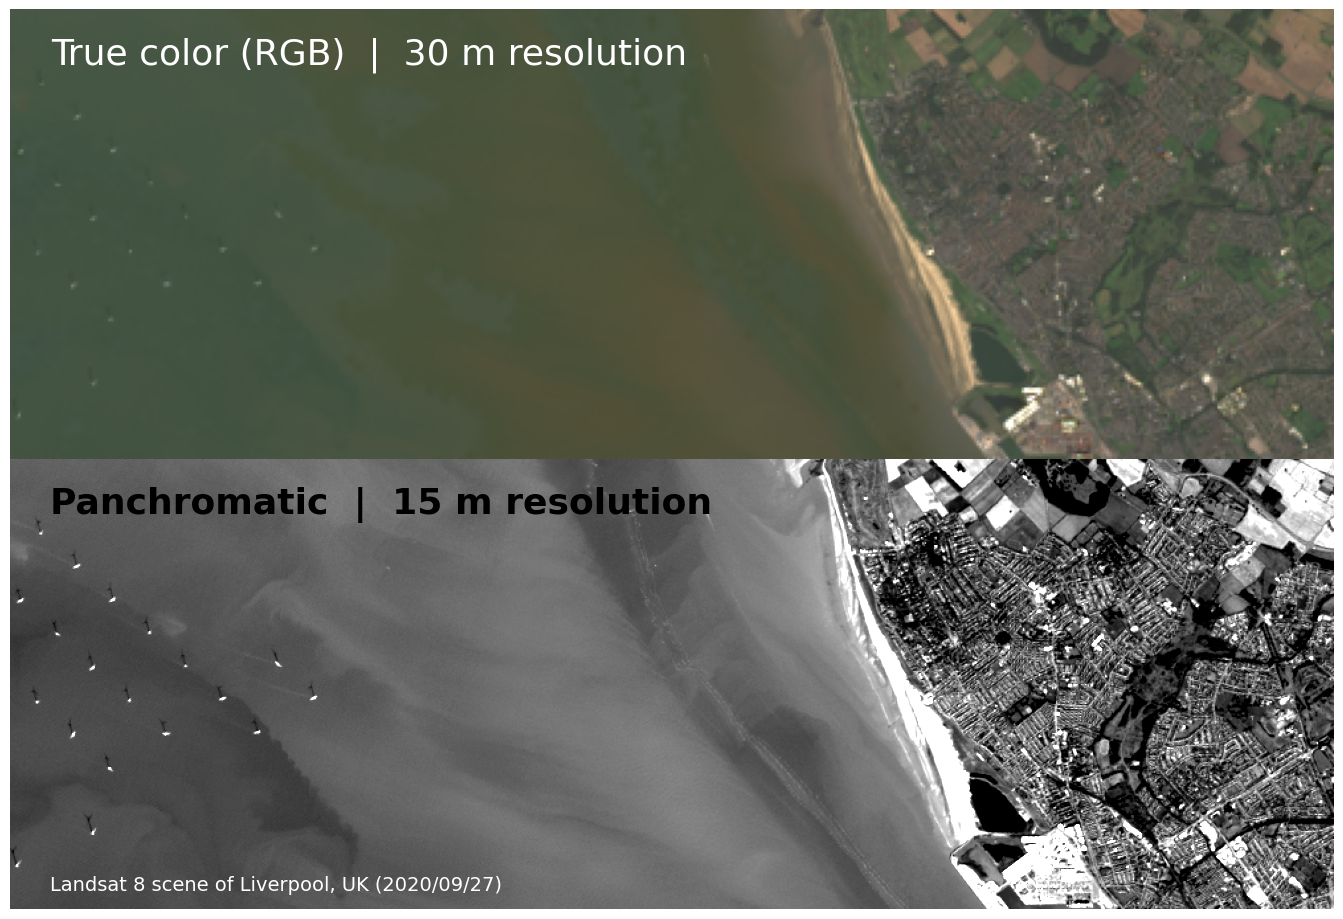

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(14, 9), dpi=100)
axes[0].imshow(truecolor)
vmin, vmax = np.percentile(liverpool_pan[8], (3, 97))
axes[1].imshow(liverpool_pan[8], cmap="gray", vmin=vmin, vmax=vmax)
axes[0].text(15, 20, "True color (RGB)  |  30 m resolution", color="white", fontsize=26)
axes[1].text(30, 40, "Panchromatic  |  15 m resolution", color="black", fontsize=26, fontweight="bold")
axes[1].text(30, liverpool_pan[8].shape[0] - 15, "Landsat 8 scene of Liverpool, UK (2020/09/27)", color="white", fontsize=14)
for ax in axes:
    ax.axis("off")
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig("../images/panchromatic-rbg-resolution.svg", bbox_inches="tight", pad_inches=0)